In [1]:
import numpy as np
import pandas as pd

In [2]:
cwwb=pd.DataFrame()
gljy=pd.DataFrame()
xyfx=pd.DataFrame()
for i in range(2011,2019):
    tmp=pd.read_excel('./财务舞弊相关数据/fraud'+str(i)+'.xlsx',sheet_name=0)
    tmp['year']=i
    cwwb=pd.concat([tmp,cwwb],ignore_index=True)
    gljy=pd.concat([pd.read_excel('./关联交易双方数据/RPT'+str(i)+'.xlsx'),gljy],ignore_index=True)
    xyfx=pd.concat([pd.read_excel('./信用风险相关数据/default'+str(i)+'.xlsx'),xyfx],ignore_index=True)

D:\Python\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
triples={}
for i in gljy.index:
    year=gljy.loc[i,'publish_date'][0:4]
    t=tuple([year+'company'+str(gljy.loc[i,'trading_code']),'relatedTransaction',year+'company'+str(gljy.loc[i,'rela_stockid'])])
    if t[0]==t[2] or gljy.loc[i,'money']==0:
        continue
    if t not in triples.keys():
        triples[t]=gljy.loc[i,'money']
    else:
        triples[t]+=gljy.loc[i,'money']

values=[(i-min(triples.values()))/(max(triples.values())-min(triples.values())) for i in triples.values()]#[0,1]
for i in range(len(values)):        
    triples[list(triples.keys())[i]]=values[i]
from tqdm import tqdm
tmpT=np.array([list(i) for i in list(triples.keys())])
X=[list(i) for i in list(triples.keys())]
for i in tqdm(range(len(tmpT))):
    c1=tmpT[i][0]
    for j in range(len(tmpT)):
        
        c2=tmpT[j][0]
        c3=tmpT[j][2]
        if c2!=c1 and c1[4:]==c2[4:]:
            t=[c1,'sameCompany',c2]
            if t not in X:
                values.append(1)
                X.append(t)
        if c3!=c1 and c1[4:]==c3[4:]:
            t=[c1,'sameCompany',c3]
            if t not in X:
                values.append(1)
                X.append(t)

100%|██████████| 1429/1429 [00:04<00:00, 341.30it/s]


In [4]:
fraudTriple={}
fraudPropertyTriple={}
for i in cwwb.index:
    year=cwwb.loc[i,'year']
    code=cwwb.loc[i,'code']
    for j in cwwb.columns:
        if j in ['year','code']:
            continue
        elif j=='label':
            continue
            # if cwwb.loc[i,j]==1:
            #     t=tuple([str(year)+'company'+str(code),'fraud','True'])
            # else:
            #     t=tuple([str(year)+'company'+str(code),'fraud','False'])
            # fraudTriple[t]=1
        else:
            t=tuple([str(year)+'company'+str(code),j,j+':'+str(cwwb.loc[i,j])])
            fraudPropertyTriple[t]=1
from sklearn.model_selection import train_test_split
#fraudTrain,fraudTest=train_test_split(fraudTriple,test_size=0.3,random_state=5)
#X+=fraudTriple
X+=[list(i) for i in list(fraudPropertyTriple.keys())]
        

In [5]:
D=pd.DataFrame(X)
D.to_csv('./triples.csv',index=False)
from ampligraph.datasets import load_from_csv
X = load_from_csv('./', 'triples.csv', sep=',')

In [ ]:
from ampligraph.latent_features import TransE,DistMult,ComplEx
from ampligraph.evaluation import train_test_split_no_unseen
X_train,X_test=train_test_split_no_unseen(X,test_size=0.15)
mr=[]
mr_test=[]
r=range(100,1301,200)
for e in r:
    print('----'+str(e)+'----')
    model = ComplEx(batches_count=1, seed=555, epochs=e, k=20, loss='pairwise',
                    loss_params={'margin':5})
    model.fit(X_train)
    from ampligraph.evaluation import evaluate_performance,mr_score
    rank=evaluate_performance(X_train,model)
    mr.append(mr_score(ranks=rank))
    rank=evaluate_performance(X_test,model)
    mr_test.append(mr_score(ranks=rank))
import matplotlib.pyplot  as plt
plt.plot(r,mr,label='train')
plt.plot(r,mr_test,label='test')
plt.show()

best epoch num:900,mr=3.81, 222.5

k=20,epoch=90：mr:267.9337801608579,hit@10:0.6761394101876675,mrr:0.3097065632601254

In [5]:
eval_set=np.array(list(triples.keys())+list(fraudTriple.keys()))
eval_set2=np.array(list(fraudPropertyTriple.keys()))
X=np.array(X)
entity_subset=list(set(eval_set[:,0])|set(eval_set[:,2]))
entity_subset2=list(set(eval_set2[:,2]))

In [6]:
from sklearn.metrics import roc_auc_score,recall_score,precision_score,f1_score,accuracy_score
from tqdm import tqdm
def my_eval_auc(eval_set,model):
    trueProb=[]
    trueLabel=eval_set[:,-1]
    for t in tqdm(eval_set):
        tmp=t.copy()
        tmp[-1]='True'
        truescore=model.predict(tmp)
        trueProb.append(truescore)
    
    truescore=[0.5 if max(truescore)-min(truescore)==0 else (max(truescore)-i)/(max(truescore-min(truescore))) for i in truescore]
    return roc_auc_score(trueLabel,trueProb)
def my_eval(eval_set,model):
    trueProb=[]
    trueLabel=eval_set[:,-1]
    trueLabel=[1 if i=='True' else 0 for i in trueLabel]
    predictLabel=[]
    for t in tqdm(eval_set):
        tv=model.predict([t[0],t[1],'True'])
        fv=model.predict([t[0],t[1],'False'])
        if tv>fv:
            predictLabel.append(1)
        else:
            predictLabel.append(0)
    
    
    return recall_score(trueLabel,predictLabel),precision_score(trueLabel,predictLabel),f1_score(trueLabel,predictLabel)


In [7]:
from ampligraph.latent_features import TransE,DistMult,ComplEx
from ampligraph.evaluation import evaluate_performance,mr_score,mrr_score,hits_at_n_score,train_test_split_no_unseen,select_best_model_ranking
import numpy as np
import random
from myKGE import myDismult,myComplex
X_train,X_test=train_test_split_no_unseen(X,test_size=100)
X_train,X_valid=train_test_split_no_unseen(X_train,test_size=100)
params={"batches_count":[10,50],"epochs":[10,100,200,500],"k":[10,20,30,50],"optimizer_params":[{"lr":0.1},{"lr":0.01}]}
m=select_best_model_ranking(myComplex,X_train,X_valid,X_test,params,entities_subset=entity_subset,verbose=True)

0it [00:00, ?it/s]

ERROR - Exception occurred for parameters:{'batches_count': 10, 'epochs': 10, 'k': 10, 'optimizer_params': {'lr': 0.1}}
ERROR - database is locked


3it [00:15,  4.47s/it]

In [10]:
m[1]

{'batches_count': 10, 'epochs': 10, 'k': 50, 'optimizer_params': {'lr': 0.01}}

In [7]:
from ampligraph.evaluation import train_test_split_no_unseen
train1,test1= train_test_split_no_unseen(X[0:6683],test_size=200)
train2=X[6683:]
train=np.concatenate([train1,train2],axis=0)
company_entity=np.array(set(X[0:6683,0])|set(X[0:6683:,2]))

In [ ]:
from ampligraph.latent_features import TransE,DistMult,ComplEx
from myKGE import myDismult,myComplex
from ampligraph.evaluation import evaluate_performance,mr_score,mrr_score,hits_at_n_score,train_test_split_no_unseen,select_best_model_ranking
import numpy as np
import random
from myKGE import myDismult,myComplex
evalResult=pd.DataFrame(columns=['mr','mrr','hit@10','number-mr','number-mrr','number-hit@10'])#,'trainRecall','trainPrecison','trianF1','testRecall','testPrecison','testF1'])
X_train=train
best_mrr=0
best_e=0
for e in range(500,1501,100):
    print('============{}============'.format(e))
    model = myComplex(seed=555, epochs=e, k=30, loss='pairwise',loss_params={'margin':5},optimizer_params={'lr':0.01})
    model.fit(X_train,numberic_entity=True)
    # falseSet=eval_set[eval_set[:,-1]=='False',:]
    # trueSet=eval_set[eval_set[:,-1]=='True',:]

    rank=evaluate_performance(train1,model,entities_subset=entity_subset)
    print('company relation train, mrr:{},hit@10:{},hit@1:{} '.format(mrr_score(rank),hits_at_n_score(rank,10),hits_at_n_score(rank,1)))
    # tmpevalset=np.array(random.sample(list(list(fraudPropertyTriple.keys())),round(0.25*len(eval_set2))))
    # rank2=evaluate_performance(tmpevalset,model,entities_subset=entity_subset2)
    # print(mr_score(ranks=rank),mrr_score(rank),hits_at_n_score(rank,10),mr_score(ranks=rank2),mrr_score(rank2),hits_at_n_score(rank2,10))
    rank=evaluate_performance(test1,model,entities_subset=entity_subset)
    print('company relation test, mrr:{},hit@10:{},hit@1:{} '.format(mrr_score(rank),hits_at_n_score(rank,10),hits_at_n_score(rank,1)))
    if mrr_score(rank)>best_mrr:
        best_mrr=mrr_score(rank)
        best_e=e
    # recall1,precision1,f11=my_eval(np.array(fraudTrain),model)
    # recall2,precision2,f12=my_eval(np.array(fraudTest),model)
   # evalResult.loc[e,:]=[mr_score(ranks=rank),mrr_score(rank),hits_at_n_score(rank,5),recall1,precision1,f11,recall2,precision2,f12]



link prediction:k=30
 e         mr       mrr    hit@10 trainRecall trainPrecison   trianF1  \
10   846.412869  0.031156  0.056568    0.654206      0.255941  0.367937   
30   169.336729  0.222928  0.477212    0.691589      0.468354  0.558491   
50    23.511796  0.384262  0.811796    0.616822      0.571429  0.593258   
70     5.693834  0.445752    0.9437    0.551402      0.641304  0.592965   
90      3.30429  0.463683  0.979357    0.528037      0.684848  0.596306   
110     2.77748  0.468213  0.986595    0.448598      0.680851  0.540845   
130    2.581769  0.468647  0.991421    0.392523      0.661417  0.492669   
150    2.478552  0.467523   0.99008    0.364486      0.678261  0.474164   
170    2.459786  0.466706  0.987668    0.345794      0.711538  0.465409   
190    2.492225  0.464746  0.985523    0.327103      0.752688  0.456026   

    testRecall testPrecison    testF1  
10    0.520833     0.157729  0.242131  
30    0.447917      0.17623  0.252941  
50     0.40625      0.18932  0.258278  
70    0.333333     0.187135    0.2397  
90        0.25     0.176471  0.206897  
110   0.208333     0.172414  0.188679  
130     0.1875     0.178218  0.182741  
150   0.166667     0.170213  0.168421  
170    0.15625     0.176471  0.165746  
190    0.15625       0.1875  0.170455 

In [ ]:
for i in cwwb.index:
    try:
        embedding=model.get_embeddings(str(cwwb.loc[i,'year'])+str(cwwb.loc[i,'code']))
        j=0
        for e in embedding:
            cwwb.loc[i,j]=e
            j+=1
    except:
        print('no embedding for:',cwwb.loc[i,'code'])


no embedding for: 28
no embedding for: 156
no embedding for: 657
no embedding for: 835
no embedding for: 937
no embedding for: 2011
no embedding for: 2049
no embedding for: 2226
no embedding for: 2338
no embedding for: 2384
no embedding for: 300083
no embedding for: 300204
no embedding for: 300450
no embedding for: 600027
no embedding for: 600177
no embedding for: 600420
no embedding for: 600486
no embedding for: 600500
no embedding for: 600570
no embedding for: 600812
no embedding for: 601068
no embedding for: 603127
no embedding for: 156
no embedding for: 401
no embedding for: 711
no embedding for: 903
no embedding for: 2011
no embedding for: 2068
no embedding for: 2385
no embedding for: 300080
no embedding for: 300087
no embedding for: 300259
no embedding for: 600027
no embedding for: 600339
no embedding for: 600570
no embedding for: 600701
no embedding for: 600708
no embedding for: 600967
no embedding for: 601666
no embedding for: 601857
no embedding for: 601992
no embedding for: 5

In [ ]:
for j in range(0,40):
    cwwb[j]=cwwb[j].fillna(np.mean(cwwb[j]))
cwwb.to_csv('cwwb.csv',index=False)

In [ ]:
FraudData=cwwb.drop(['label','year'],axis=1).values
FraudLabl=cwwb.loc[:,'label'].values
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:

#cwwb1=cwwb.sample(frac=1)
from sklearn.model_selection import KFold
from sklearn import metrics

kf=KFold(n_splits=5,random_state=1,shuffle=True)
auc=[]
recall=[]
precision=[]
for train_index, test_index in kf.split(FraudData):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = FraudData[train_index], FraudData[test_index]
    y_train, y_test = FraudLabl[train_index], FraudLabl[test_index]
    n =160
    #print('=======estimators num={}========'.format(n))
    clf = RandomForestClassifier(n_estimators=n,random_state=0,class_weight='balanced')
    clf.fit(X_train,y_train)
    y_prob=clf.predict_proba(X_test)
    y_prob=y_prob[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    auc.append(metrics.roc_auc_score(y_test,y_prob))
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    y_pred=[1 if i > optimal_th else 0 for i in y_prob]
    recall.append(metrics.recall_score(y_test,y_pred))
    precision.append(metrics.precision_score(y_test,y_pred))
print('mean auc:{}, auc list:'.format(np.mean(auc)),auc)
print('mean precision: {}, precision list'.format(np.mean(precision)),precision)
print('mean recall:{}, recall list:'.format(np.mean(recall)),recall)

mean auc:0.7055919477495596, auc list: [0.7043268255063522, 0.6713404520008295, 0.703614025647924, 0.7431139122315593, 0.7055645233611334]
mean precision: 0.2504802721072593, precision list [0.25757575757575757, 0.18385650224215247, 0.2773722627737226, 0.2727272727272727, 0.2608695652173913]
mean recall:0.7213948259789345, recall list: [0.7183098591549296, 0.7735849056603774, 0.6031746031746031, 0.75, 0.7619047619047619]


保证n不变：AUC 0.718 => 0.722
重新选择n： AUC 0.718 => 0.725

In [ ]:
import xgboost
params = {"objective": "binary:logistic", 'learning_rate': 0.1,"lambda":10}
Dmatrix=xgboost.DMatrix(data=FraudData,label=FraudLabl)
res=xgboost.cv(params,Dmatrix,nfold=5,num_boost_round=50,metrics=['auc','error'])
print('train auc mean:{},test auc mean:{}'.format(res.loc[49,'train-auc-mean'],res.loc[49,'test-auc-mean']))

train auc mean:0.9932312,test auc mean:0.673795


In [ ]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
kf=KFold(n_splits=5,random_state=1,shuffle=True)
for n in range(100,1001,100):
    print('=======estimators num={}========'.format(n))
    auc=[]
    recall=[]
    precision=[]
    for train_index, test_index in kf.split(FraudData):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = FraudData[train_index], FraudData[test_index]
        y_train, y_test = FraudLabl[train_index], FraudLabl[test_index]
        #n =130
        
        clf = RandomForestClassifier(n_estimators=n,random_state=0,class_weight='balanced')
        clf.fit(X_train,y_train)
        y_prob=clf.predict_proba(X_test)
        y_prob=y_prob[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
        roc_auc = metrics.auc(fpr, tpr)
        auc.append(metrics.roc_auc_score(y_test,y_prob))
        optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
        y_pred=[1 if i > optimal_th else 0 for i in y_prob]
        recall.append(metrics.recall_score(y_test,y_pred))
        precision.append(metrics.precision_score(y_test,y_pred))
    print('mean auc:{}, auc list:'.format(np.mean(auc)),auc)
    print('mean precision: {}, precision list'.format(np.mean(precision)),precision)
    print('mean recall:{}, recall list:'.format(np.mean(recall)),recall)

=======estimators num=100========
mean auc:0.7126893231186944, auc list: [0.7264277306490238, 0.7368598382749325, 0.7013944937673752, 0.6867880485527544, 0.7119765043493856]
mean precision: 0.2503972107478419, precision list [0.2672811059907834, 0.22972972972972974, 0.22705314009661837, 0.2636363636363636, 0.2642857142857143]
mean recall:0.655015501815927, recall list: [0.8169014084507042, 0.6415094339622641, 0.746031746031746, 0.48333333333333334, 0.5873015873015873]
=======estimators num=200========
mean auc:0.7275051102002037, auc list: [0.7306490238259528, 0.7554167530582625, 0.7304501838400143, 0.702217553688142, 0.7187920365886468]
mean precision: 0.27225331694832344, precision list [0.2543103448275862, 0.22857142857142856, 0.33695652173913043, 0.25675675675675674, 0.2846715328467153]
mean recall:0.6660294682138955, recall list: [0.8309859154929577, 0.7547169811320755, 0.49206349206349204, 0.6333333333333333, 0.6190476190476191]
=======estimators num=300========
mean auc:0.733854

best model of randomforest:
n=700
mean auc:0.7422971844636367, auc list: [0.7442261638998254, 0.7475378395189716, 0.7536768002869697, 0.7372315592903829, 0.7288135593220337]
mean precision: 0.2753577962403141, precision list [0.29518072289156627, 0.21761658031088082, 0.30656934306569344, 0.2541436464088398, 0.30327868852459017]
mean recall:0.7006457191788045, recall list: [0.6901408450704225, 0.7924528301886793, 0.6666666666666666, 0.7666666666666667, 0.5873015873015873]

best f1: 0.42500000000000004


D:\Python\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


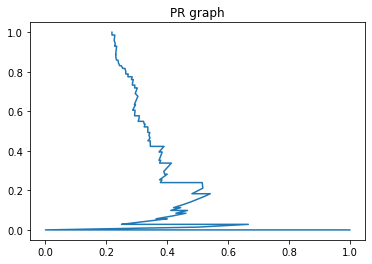

D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best f1: 0.35460992907801425


D:\Python\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


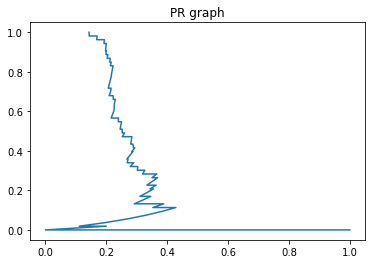

best f1: 0.42622950819672134


D:\Python\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


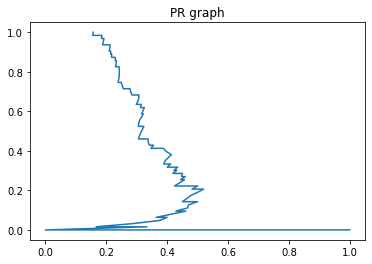

best f1: 0.43356643356643354


D:\Python\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


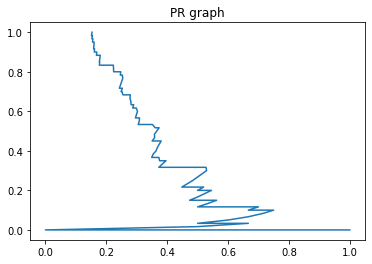

D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best f1: 0.418848167539267


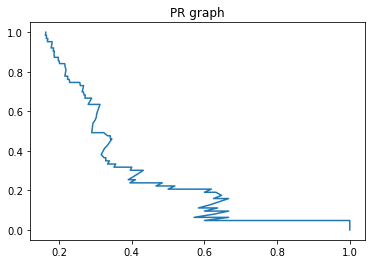

mean auc:0.7422971844636367, auc list: [0.7442261638998254, 0.7475378395189716, 0.7536768002869697, 0.7372315592903829, 0.7288135593220337]
mean precision: 0.060655737704918035, precision list [0.0, 0.0, 0.0, 0.0, 0.30327868852459017]
mean recall:0.11746031746031746, recall list: [0.0, 0.0, 0.0, 0.0, 0.5873015873015873]


In [7]:
#best model of RF
import matplotlib.pylab as plt
auc=[]
recall=[]
precision=[]
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
kf=KFold(n_splits=5,random_state=1,shuffle=True)
for train_index, test_index in kf.split(FraudData):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = FraudData[train_index], FraudData[test_index]
    y_train, y_test = FraudLabl[train_index], FraudLabl[test_index]
    #n =130
    
    clf = RandomForestClassifier(n_estimators=700,random_state=0,class_weight='balanced')
    clf.fit(X_train,y_train)
    y_prob=clf.predict_proba(X_test)
    y_prob=y_prob[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    p,r,th=metrics.precision_recall_curve(y_test,y_prob)
    f1s=[(2*p*r/(p+r)) for p, r in zip(p, r)]
    optimal_f1_index=np.argmax(f1s)
    optimal_th=th[optimal_f1_index]
    print('best f1:',max(f1s))
    plt.plot(p,r)
    plt.title('PR graph')
    plt.show()
    roc_auc = metrics.auc(fpr, tpr)
    auc.append(metrics.roc_auc_score(y_test,y_prob))
    #optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    y_pred=[1 if i > optimal_th else 0 for i in y_prob]
    recall.append(metrics.recall_score(y_test,y_pred))
    precision.append(metrics.precision_score(y_test,y_pred))
print('mean auc:{}, auc list:'.format(np.mean(auc)),auc)
print('mean precision: {}, precision list'.format(np.mean(precision)),precision)
print('mean recall:{}, recall list:'.format(np.mean(recall)),recall)

In [ ]:
import xgboost as xgb

params = {"objective": "binary:logistic", 'learning_rate': 0.1,"lambda":10,"n_estimators":50}
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point
#cwwb1=cwwb.sample(frac=1)
from sklearn.model_selection import KFold
from sklearn import metrics
kf=KFold(n_splits=5,random_state=1,shuffle=True)
meanAuc=[]
meanRecall=[]
meanPrecision=[]
r=range(100,300,10)
for n in r:
    auc=[]
    recall=[]
    precision=[]
    for train_index, test_index in kf.split(FraudData):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = FraudData[train_index], FraudData[test_index]
        y_train, y_test = FraudLabl[train_index], FraudLabl[test_index]
        #print('=======estimators num={}========'.format(n))
        xgboostModel = xgb.XGBClassifier(n_estimators=n,learning_rate=0.1,reg_lambda=1,use_label_encoder=False,eval_metric=metrics.log_loss)
        xgboostModel.fit(X_train,y_train)
        y_prob=xgboostModel.predict_proba(X_test)
        y_prob=y_prob[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
        roc_auc = metrics.auc(fpr, tpr)
        auc.append(metrics.roc_auc_score(y_test,y_prob))
        optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
        y_pred=[1 if i > optimal_th else 0 for i in y_prob]
        recall.append(metrics.recall_score(y_test,y_pred))
        precision.append(metrics.precision_score(y_test,y_pred))
    meanAuc.append(np.mean(auc))
    meanPrecision.append(np.mean(precision))
    meanRecall.append(np.mean(recall))
import matplotlib.pyplot  as plt
plt.plot(r,meanAuc,label='AUC')
plt.plot(r,meanPrecision,label='precision')
plt.plot(r,meanRecall,label='recall')
plt.show()

[15:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


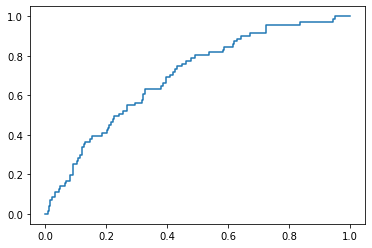

[15:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


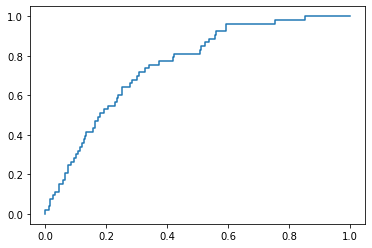

[15:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


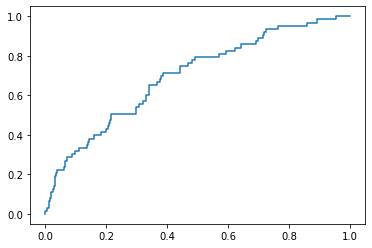

[15:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


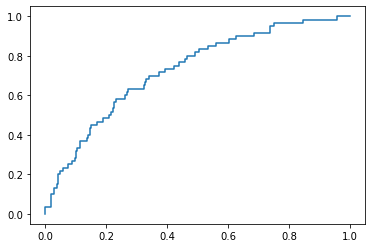

[15:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


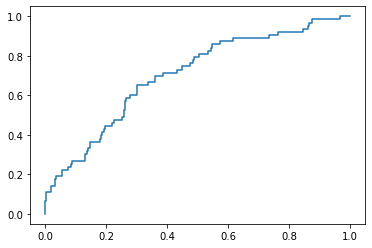

In [16]:
#best model for xgboost
auc=[]
recall=[]
precision=[]
for train_index, test_index in kf.split(FraudData):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = FraudData[train_index], FraudData[test_index]
    y_train, y_test = FraudLabl[train_index], FraudLabl[test_index]
    #print('=======estimators num={}========'.format(n))
    xgboostModel = xgb.XGBClassifier(n_estimators=170,learning_rate=0.1,reg_lambda=1,use_label_encoder=False,eval_metric=metrics.log_loss)
    xgboostModel.fit(X_train,y_train)
    y_prob=xgboostModel.predict_proba(X_test)
    y_prob=y_prob[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    plt.plot(fpr,tpr)
    plt.show()
    roc_auc = metrics.auc(fpr, tpr)
    auc.append(metrics.roc_auc_score(y_test,y_prob))
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    y_pred=[1 if i > optimal_th else 0 for i in y_prob]
    recall.append(metrics.recall_score(y_test,y_pred))
    precision.append(metrics.precision_score(y_test,y_pred))
meanAuc.append(np.mean(auc))
meanPrecision.append(np.mean(precision))
meanRecall.append(np.mean(recall))

最优参数 n=170，l=1
auc=0.7161,precision=0.2576,recall=0.7465

In [14]:
from ampligraph.evaluation import mrr_score,hits_at_n_score,mr_score
from ampligraph.evaluation import train_test_split_no_unseen,evaluate_performance
X_train,X_test=train_test_split_no_unseen(X,test_size=0.15)
rank=evaluate_performance(X_train,model)
print(mr_score(rank))
print(mrr_score(rank))
print(hits_at_n_score(rank,3))
print(hits_at_n_score(rank,10))

3.810454065469905
0.35127890228444414
0.6033966913058783
0.9909362900387187


In [ ]:
###related transaction: numberic encoder KGE(full info) + random foreast(linear schema)
cwwb=pd.DataFrame()
gljy=pd.DataFrame()
xyfx=pd.DataFrame()
for i in range(2011,2019):
    tmp=pd.read_excel('./财务舞弊相关数据/fraud'+str(i)+'.xlsx',sheet_name=0)
    tmp['year']=i
    cwwb=pd.concat([tmp,cwwb],ignore_index=True)
    gljy=pd.concat([pd.read_excel('./关联交易双方数据/RPT'+str(i)+'.xlsx'),gljy],ignore_index=True)
    xyfx=pd.concat([pd.read_excel('./信用风险相关数据/default'+str(i)+'.xlsx'),xyfx],ignore_index=True)
###KG construct
triples={}
for i in gljy.index:
    year=gljy.loc[i,'publish_date'][0:4]
    t=tuple([year+'company'+str(gljy.loc[i,'trading_code']),year+gljy.loc[i,'rela_type'],year+str(gljy.loc[i,'rela_stockid'])])
    if t[0]==t[2] or gljy.loc[i,'money']==0:
        continue
    if t not in triples.keys():
        triples[t]=gljy.loc[i,'money']
    else:
        triples[t]+=gljy.loc[i,'money']

values=[(i-min(triples.values()))/(max(triples.values())-min(triples.values())) for i in triples.values()]#[0,1]
for i in range(len(values)):        
    triples[list(triples.keys())[i]]=values[i]
from tqdm import tqdm
tmpT=np.array([list(i) for i in list(triples.keys())])
X=[list(i) for i in list(triples.keys())]
for i in tqdm(range(len(tmpT))):
    c1=tmpT[i][0]
    for j in range(len(tmpT)):
        
        c2=tmpT[j][0]
        c3=tmpT[j][2]
        if c2!=c1 and c1[4:]==c2[4:]:
            t=[c1,'sameCompany',c2]
            if t not in X:
                values.append(1)
                X.append(t)
        if c3!=c1 and c1[4:]==c3[4:]:
            t=[c1,'sameCompany',c3]
            if t not in X:
                values.append(1)
                X.append(t)
fraudTriple={}
fraudPropertyTriple={}
for i in cwwb.index:
    year=cwwb.loc[i,'year']
    code=cwwb.loc[i,'code']
    for j in cwwb.columns:
        if j in ['year','code']:
            continue
        elif j=='label':
            continue
        else:
            t=tuple([str(year)+'company'+str(code),j,j+':'+str(cwwb.loc[i,j])])
            fraudPropertyTriple[t]=1
from sklearn.model_selection import train_test_split
from myKGE import myComplex
X+=[list(i) for i in list(fraudPropertyTriple.keys())]
eval_set=np.array(list(triples.keys())+list(fraudTriple.keys()))
X=np.array(X)
entity_subset=list(set(eval_set[:,0])|set(eval_set[:,2]))
model = myComplex(batches_count=1, seed=555, epochs=1200, k=30, loss='pairwise',
                        loss_params={'margin':5})
model.fit(X,numberic_entity=True)
from ampligraph.utils import save_model
save_model(model,'./numberic-encoder-rt.model')
newCWWB=cwwb
for i in cwwb.index:
    try:
        embedding=model.get_embeddings(str(cwwb.loc[i,'year'])+'company'+str(cwwb.loc[i,'code']))
        j=0
        for e in embedding:
            newCWWB.loc[i,j]=e
            j+=1
    except:
        print('no embedding for:',cwwb.loc[i,'code'])
newCWWB['label']=cwwb['label']
for j in range(0,40):
    newCWWB[j]=newCWWB[j].fillna(np.mean(newCWWB[j]))
FraudData=newCWWB.drop(['label','year'],axis=1).values
FraudLabl=newCWWB.loc[:,'label'].values
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point
#cwwb1=cwwb.sample(frac=1)
from sklearn.model_selection import KFold
from sklearn import metrics
kf=KFold(n_splits=5,random_state=1,shuffle=True)



100%|██████████| 1644/1644 [00:03<00:00, 431.23it/s]


WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [ ]:
newCWWB=cwwb
for i in cwwb.index:
    try:
        embedding=model.get_embeddings(str(cwwb.loc[i,'year'])+'company'+str(cwwb.loc[i,'code']))
        j=0
        for e in embedding:
            newCWWB.loc[i,j]=e
            j+=1
    except:
        print('no embedding for:',cwwb.loc[i,'code'])
newCWWB['label']=cwwb['label']
for j in range(0,40):
    newCWWB[j]=newCWWB[j].fillna(np.mean(newCWWB[j]))
FraudData=newCWWB.drop(['label','year'],axis=1).values
FraudLabl=newCWWB.loc[:,'label'].values
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point
#cwwb1=cwwb.sample(frac=1)
from sklearn.model_selection import KFold
from sklearn import metrics
kf=KFold(n_splits=5,random_state=1,shuffle=True)


In [ ]:
for n in range(1450,2500,100):
    print(n)
    auc=[]
    recall=[]
    precision=[]
    for train_index, test_index in kf.split(FraudData):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = FraudData[train_index], FraudData[test_index]
        y_train, y_test = FraudLabl[train_index], FraudLabl[test_index]
        
        #print('=======estimators num={}========'.format(n))
        clf = RandomForestClassifier(n_estimators=n,random_state=0,class_weight='balanced')
        clf.fit(X_train,y_train)
        y_prob=clf.predict_proba(X_test)
        y_prob=y_prob[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
        roc_auc = metrics.auc(fpr, tpr)
        auc.append(metrics.roc_auc_score(y_test,y_prob))
        optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
        y_pred=[1 if i > optimal_th else 0 for i in y_prob]
        recall.append(metrics.recall_score(y_test,y_pred))
        precision.append(metrics.precision_score(y_test,y_pred))
    print('mean auc:{}, auc list:'.format(np.mean(auc)),auc)
    print('mean precision: {}, precision list'.format(np.mean(precision)),precision)
    print('mean recall:{}, recall list:'.format(np.mean(recall)),recall)

In [6]:
import pandas as pd
cwwb=pd.DataFrame()
gljy=pd.DataFrame()
for i in range(2011,2019):
    tmp=pd.read_excel('./财务舞弊相关数据/fraud'+str(i)+'.xlsx',sheet_name=0)
    tmp['year']=i
    cwwb=pd.concat([tmp,cwwb],ignore_index=True)
    gljy=pd.concat([pd.read_excel('./关联交易双方数据/RPT'+str(i)+'.xlsx'),gljy],ignore_index=True)
ind=pd.read_csv('./ind.csv')

ind.rename({'Symbol':'code'},axis=1,inplace=True)
ind['year']=ind['EndDate'].apply(lambda x:int(x[0:4]))

newCWWB=pd.merge(cwwb,ind[['year','code','IndustryCode']],on=['year','code'],how='left')
newCWWB.fillna('nan',inplace=True)

industry=newCWWB['IndustryCode'].value_counts()
indDict={}
for i in range(len(industry)):
    indDict[industry.index[i]]=i
newCWWB['IndustryCode']=newCWWB['IndustryCode'].apply(lambda x:indDict[x])
newCWWB.to_csv('newcwwb.csv',index=False)

D:\Python\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [1]:

from ampligraph.datasets import load_from_csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from myKGE import myComplex
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn import metrics,preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost
import itertools
import random
import math
def train_val_test_split(X,y,train_ratio,test_ratio):
    node_num=len(y)
    ids = [i for i in range(node_num)]
    random.seed(55)
    random.shuffle(ids)
    
    train_ids = ids[0: math.ceil(train_ratio * node_num)]
    test_ids = ids[math.ceil(train_ratio*node_num): math.ceil((test_ratio+train_ratio)*node_num)]
    val_ids = ids[math.ceil((test_ratio+train_ratio)*node_num):]
    train_X,train_y= X[train_ids,:],y[train_ids]
    test_X,test_y=X[test_ids,:],y[test_ids]
    val_X,val_y=X[val_ids,:],y[val_ids]
    return train_X,train_y,test_X,test_y,val_X,val_y
def KGconstruct(cwwb,gljy,property=True):
    ###related transaction: numberic encoder KGE(full info) + random foreast(linear schema)
    ###KG construct
    # normalizedCwwb=pd.DataFrame(preprocessing.minmax_scale(cwwb.values),columns=cwwb.columns)
    # normalizedCwwb[['year','label','code']]=cwwb[['year','label','code']]
    triples={}
    for i in gljy.index:
        year=gljy.loc[i,'publish_date'][0:4]
        t=tuple([year+'company'+str(gljy.loc[i,'trading_code']),'relatedTransaction',year+'company'+str(gljy.loc[i,'rela_stockid'])])
        if t[0]==t[2] or gljy.loc[i,'money']==0:
            continue
        if t not in triples.keys():
            triples[t]=gljy.loc[i,'money']
        else:
            triples[t]+=gljy.loc[i,'money']

    values=[(i-min(triples.values()))/(max(triples.values())-min(triples.values())) for i in triples.values()]#[0,1]
    for i in range(len(values)):        
        triples[list(triples.keys())[i]]=values[i]

    tmpT=np.array([list(i) for i in list(triples.keys())])
    X=[list(i) for i in list(triples.keys())]
    for i in tqdm(range(len(tmpT))):
        c1=tmpT[i][0]
        for j in range(len(tmpT)):
            
            c2=tmpT[j][0]
            c3=tmpT[j][2]
            if c2!=c1 and c1[4:]==c2[4:]:
                t=[c1,'sameCompany',c2]
                if t not in X:
                    values.append(1)
                    X.append(t)
            if c3!=c1 and c1[4:]==c3[4:]:
                t=[c1,'sameCompany',c3]
                if t not in X:
                    values.append(1)
                    X.append(t)
    fraudTriple={}
    fraudPropertyTriple={}
    for i in cwwb.index:
        year=cwwb.loc[i,'year']
        code=cwwb.loc[i,'code']
        for j in cwwb.columns:
            if j in ['year','code']:
                continue
            elif j=='label':
                continue
            else:
                if property:
                    t=tuple([str(year)+'company'+str(code),j,j+':'+str(cwwb.loc[i,j])])
                    fraudPropertyTriple[t]=1
                else:
                    continue

    X+=[list(i) for i in list(fraudPropertyTriple.keys())]
    eval_set=np.array(list(triples.keys())+list(fraudTriple.keys()))
    X=np.array(X)
    entity_subset=list(set(eval_set[:,0])|set(eval_set[:,2]))
    return X,eval_set,entity_subset
def KGE(X,eval_set,entity_subset,dim=15,epoch=2000):
    model = myComplex(seed=555, epochs=epoch, k=dim, loss='pairwise',
                            optimizer_params={'lr':0.01})
    model.fit(X,numeric_entity=False)
    from ampligraph.utils import save_model
    save_model(model,'./numberic-encoder-rt.model')
    return model

def get_embedding(model,cwwb,with_row_feature=True):
    if with_row_feature:
        newCWWB=cwwb
    else:
        newCWWB=pd.DataFrame()
    for i in cwwb.index:
        try:
            embedding=model.get_embeddings(str(cwwb.loc[i,'year'])+'company'+str(cwwb.loc[i,'code']))
            j=0
            for e in embedding:
                newCWWB.loc[i,j]=e
                j+=1
        except:
            print('no embedding for:',cwwb.loc[i,'code'])
    
    for j in range(0,len(embedding)):
        newCWWB[j]=newCWWB[j].fillna(np.mean(newCWWB[j]))
    newCWWB['label']=cwwb['label']
    if with_row_feature:
        FraudData=newCWWB.drop(['label','year'],axis=1).values
    else:
        FraudData=newCWWB.drop(['label'],axis=1).values
    FraudLabl=newCWWB.loc[:,'label'].values
    return FraudData,FraudLabl
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point


def myrandomforest(FraudData,FraudLabel,params):

    #X_train, X_test, y_train, y_test= train_test_split( FraudData,FraudLabel,random_state=5)
    X_train, y_train, X_test, y_test,X_val,y_val=train_val_test_split(FraudData,FraudLabel,train_ratio=0.7,test_ratio=0.1)
    #print('=======estimators num={}========'.format(n))

    clf = RandomForestClassifier(n_estimators=params,random_state=0,class_weight='balanced')
    clf.fit(X_train,y_train)
    y_prob=clf.predict_proba(X_train)
    y_prob=y_prob[:,1]
    trainauc=metrics.roc_auc_score(y_train,y_prob)
    y_prob=clf.predict_proba(X_val)
    y_prob=y_prob[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    auc=metrics.roc_auc_score(y_val,y_prob)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    y_pred=[1 if i > optimal_th else 0 for i in y_prob]
    recall=metrics.recall_score(y_val,y_pred)
    precision=metrics.precision_score(y_val,y_pred)
    # print('mean auc:{}, auc list:'.format(np.mean(auc)),auc)
    # print('mean precision: {}, precision list'.format(np.mean(precision)),precision)
    # print('mean recall:{}, recall list:'.format(np.mean(recall)),recall)
    # predict_result.loc[i,:]=[np.mean(auc),np.mean(precision),np.mean(recall)]}
    return trainauc,auc,recall,precision
def myxgboost(FraudData,FraudLabel,params):
    X_train,X_test, y_train, y_test,X_val,y_val=train_val_test_split(FraudData,FraudLabel,train_ratio=0.7,test_ratio=0.1)
    aucList=[]
    #print('=======estimators num={}========'.format(n))
    Dmatrix=xgboost.DMatrix(data=X_train,label=y_train)
    Dval=xgboost.DMatrix(data=X_val,label=y_val)
    Dtest=xgboost.DMatrix(data=X_test,label=y_test)
    model=xgboost.train(params,Dmatrix,num_boost_round=2000,early_stopping_rounds=100,evals=[ (Dmatrix, 'train'),(Dval, 'eval')],verbose_eval=False)
    auc,best_iter=model.best_score, model.best_iteration
    # y_prob=model.predict(Dtest)
    # fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    aucList.append(auc)
    model=xgboost.train(params,Dmatrix,num_boost_round=best_iter)
    y_prob=model.predict(Dtest)
    testAuc=metrics.roc_auc_score(y_test,y_prob)
    # optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    # y_pred=[1 if i > optimal_th else 0 for i in y_prob]
    # recall.append(metrics.recall_score(y_test,y_pred))
    # precision.append(metrics.precision_score(y_test,y_pred))
    # print('mean precision: {}, precision list'.format(np.mean(precision)),precision)
    # print('mean recall:{}, recall list:'.format(np.mean(recall)),recall)
    return np.mean(aucList)
def myNN(FraudData,FraudLabel,params):
    X_train, y_train, X_val,y_val,X_test, y_test=train_val_test_split(FraudData,FraudLabel,train_ratio=0.7,test_ratio=0.1)
    mlp = MLPClassifier(hidden_layer_sizes=params[0],alpha=params[1],max_iter=10000,learning_rate_init=params[2],learning_rate='adaptive',activation=params[3]) 
    mlp.fit(X_train, y_train,FPweight=params[4])
    y_prob=mlp.predict_proba(X_test)
    y_prob=y_prob[:,1]
    test_auc= metrics.roc_auc_score(y_test,y_prob)
    y_prob=mlp.predict_proba(X_train)
    y_prob=y_prob[:,1]
    train_auc=metrics.roc_auc_score(y_train,y_prob)
   
    return train_auc,test_auc
cwwb=pd.DataFrame()
gljy=pd.DataFrame()
for i in range(2011,2019):
    tmp=pd.read_excel('./财务舞弊相关数据/fraud'+str(i)+'.xlsx',sheet_name=0)
    tmp['year']=i
    cwwb=pd.concat([tmp,cwwb],ignore_index=True)
    gljy=pd.concat([pd.read_excel('./关联交易双方数据/RPT'+str(i)+'.xlsx'),gljy],ignore_index=True)
newcwwb=pd.read_csv('newcwwb.csv')
X,eval_set,entity_subset=KGconstruct(newcwwb,gljy,property=False)

print('successfully construct KG')
#result=pd.DataFrame(columns=['lambda','gamma','eta','maxdepth','auc','KGdim'])

# model=KGE(X,eval_set,entity_subset,dim=15,epoch=500)
   
# FraudData,FraudLabel=get_embedding(model,cwwb,with_row_feature=True)
    

D:\Python\lib\site-packages\ipykernel_launcher.py:196: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 1429/1429 [00:04<00:00, 347.52it/s]

successfully construct KG


In [2]:
model=KGE(X,eval_set,entity_subset,dim=15,epoch=1000)
   
FraudData,FraudLabel=get_embedding(model,cwwb,with_row_feature=True)

no embedding for: 28
no embedding for: 156
no embedding for: 657
no embedding for: 835
no embedding for: 937
no embedding for: 2011
no embedding for: 2049
no embedding for: 2226
no embedding for: 2338
no embedding for: 2384
no embedding for: 300083
no embedding for: 300204
no embedding for: 300450
no embedding for: 600027
no embedding for: 600177
no embedding for: 600420
no embedding for: 600486
no embedding for: 600500
no embedding for: 600570
no embedding for: 600812
no embedding for: 601068
no embedding for: 603127
no embedding for: 156
no embedding for: 401
no embedding for: 711
no embedding for: 903
no embedding for: 2011
no embedding for: 2068
no embedding for: 2385
no embedding for: 300080
no embedding for: 300087
no embedding for: 300259
no embedding for: 600027
no embedding for: 600339
no embedding for: 600570
no embedding for: 600701
no embedding for: 600708
no embedding for: 600967
no embedding for: 601666
no embedding for: 601857
no embedding for: 601992
no embedding for: 5

In [7]:
from tqdm import tqdm
import logging
class experiment_protocal():
    def __init__(self,params_dict,model,exp_name,triples=[]):
        self.parmas_dict=params_dict
        self.model=model
        self.exp_name=exp_name
        self.triples=triples
        self.logger = logging.getlogger(__name__)
        self.logger.setLevel(level = logging.INFO)
        handler = logging.FileHandler('./log/'+self.exp_name+'.txt')
        handler.setLevel(logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)
        self.logger.info("Start print log")
    def cv_train_test_split(self,X,y,cv_num,seed=5):
        kf=KFold(n_splits=cv_num,shuffle=True,random_state=seed)
        k=0
        return kf.split(X,y)
    def select_best_model(self,X,y,cv_num=5,seed=5):
        result=[]
        k=0
        for params in tqdm(self.parmas_dict):
            if self.model=='RF':
                clf = RandomForestClassifier(n_estimators=params.get('n_estimators',100),random_state=0,class_weight='balanced',max_depth=params.get('max_depth',10),\
                    min_samples_leaf=params.get('min_sample_leaf',1))
                kf=KFold(n_splits=cv_num,random_state=seed,shuffle=True)
                auc=[]
                for train_index, test_index in kf.split(X,y):
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    #n =130
                    clf.fit(X_train,y_train)
                    y_prob=clf.predict_proba(X_test)
                    y_prob=y_prob[:,1]
                    auc.append(metrics.roc_auc_score(y_test,y_prob))
                result.append(np.mean(auc))
            elif self.model=='XGBoost':
                kf=KFold(n_splits=cv_num,random_state=seed,shuffle=True)
                auc=[]
                for train_index, test_index in kf.split(X,y):
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    Dtrain=xgboost.DMatrix(X_train,y_train)
                    Dval=xgboost.DMatrix(X_test,y_test)
                    model=xgboost.train(params,Dtrain,num_boost_round=2000,early_stopping_rounds=100,evals=[ (Dtrain, 'train'),(Dval, 'eval')],verbose_eval=False)
                    y_prob=model.predict(Dval)
                    auc.append(metrics.roc_auc_score(y_test,y_prob))
                result.append(np.mean(auc))
        return self.parmas_dict[np.argmax(result)],max(result)
    def run_model(self,X_train,y_train,X_test,y_test,params):
        if self.model=='RF':
            clf = RandomForestClassifier(n_estimators=params.get('n_estimators',100),random_state=0,class_weight='balanced',max_depth=params.get('max_depth',10),\
                    min_samples_leaf=params.get('min_sample_leaf',1))
            clf.fit(X_train,y_train)
            y_prob=clf.predict_proba(X_test)
            y_prob=y_prob[:,1]
            testauc=(metrics.roc_auc_score(y_test,y_prob))
            y_prob=clf.predict_proba(X_train)
            y_prob=y_prob[:,1]
            trainauc=(metrics.roc_auc_score(y_train,y_prob))
            return trainauc,testauc
        elif self.model=='XGBoost':
            Dtrain=xgboost.DMatrix(X_train,y_train)
            Dval=xgboost.DMatrix(X_test,y_test)
            model=xgboost.train(params,Dtrain,num_boost_round=2000,early_stopping_rounds=100,evals=[ (Dtrain, 'train'),(Dval, 'eval')],verbose_eval=False)
            y_prob=model.predict(Dval)
            testauc=metrics.roc_auc_score(y_test,y_prob)
            y_prob=model.predict(Dtrain)
            trainauc=metrics.roc_auc_score(y_train,y_prob)
            return trainauc,testauc
        
    def get_embedding(self,model,cwwb,with_row_feature=True):
        if with_row_feature:
            newCWWB=cwwb
        else:
            newCWWB=pd.DataFrame()
        for i in cwwb.index:
            try:
                embedding=model.get_embeddings(str(cwwb.loc[i,'year'])+'company'+str(cwwb.loc[i,'code']))
                j=0
                for e in embedding:
                    newCWWB.loc[i,j]=e
                    j+=1
            except:
                print('no embedding for:',cwwb.loc[i,'code'])
        
        for j in range(0,len(embedding)):
            newCWWB[j]=newCWWB[j].fillna(np.mean(newCWWB[j]))
        newCWWB['label']=cwwb['label']
        if with_row_feature:
            FraudData=newCWWB.drop(['label','year'],axis=1).values
        else:
            FraudData=newCWWB.drop(['label'],axis=1).values
        FraudLabl=newCWWB.loc[:,'label'].values
        return FraudData,FraudLabl
    def prepareKGE(self,X,embedding_dim,epoch):
        emb=[]
        emb_params=[]
        for d in embedding_dim:
            for e in epoch:
                emb_params.append([d,e])
                model = myComplex(seed=555, epochs=e, k=d, loss='pairwise',
                            optimizer_params={'lr':0.01})
                model.fit(self.triples,numeric_entity=True)
                emb.append(self.get_embedding(model,X,with_row_feature=True))
        return emb,emb_params
    def run(self,X,y,cv_num):
        
        split=self.cv_train_test_split(X,y,cv_num)
        test_re=[]
        val_re=[]
        k=0
        for train_id,test_id in split:
            print('train test split {}'.format(k))
            self.logger.info('train test split {}'.format(k))
            train_X,test_X,train_y,test_y=X[train_id],X[test_id],y[train_id],y[test_id]
            best_params,best_auc=self.select_best_model(train_X,train_y)
            print('best params:{},bets auc on val set:{}'.format(best_params,best_auc))
            self.logger.info('best params:{},bets auc on val set:{}'.format(best_params,best_auc))
            trainauc,testauc=self.run_model(train_X,train_y,test_X,test_y,best_params)
            print('test auc:{}'.format(testauc))
            self.logger.info('test auc:{}'.format(testauc))
            test_re.append(testauc)
            val_re.append(best_auc)
            k+=1
        self.logger.info('validation set result:{}'.format(val_re))
        self.logger.info('test set result:{}'.format(test_re))
        return test_re,val_re

simple KGE + concatenate featrues

XGBoost [0.7076839434577745,
 0.6395730706075534,
 0.6188081936685289,
 0.7081689029202841,
 0.7511559478772594,
 0.7141176470588235,
 0.6265917602996255,
 0.7490079365079365,
 0.7202247191011236,
 0.7253869969040248]
**mean:0.69**

 RF 
[0.7200072490032621,
 0.6980295566502462,
 0.7035381750465549,
 0.7093528018942383,
 0.7461118116855822,
 0.7510924369747899,
 0.704119850187266,
 0.8099206349206349,
 0.7524344569288389,
 0.7829721362229103]
 **mean 0.738**

In [10]:
# simple KGE + concatenate featrues
lambdaList=[0.01,0.1,1]
gammaList=[0.01,0]
maxdepthList=[3,5,7]
pos_weight=[1,1.5,1.75,2.0]
#sub_sample=[0.5,0.7,0.9]
eta=[0.1,0.01]
names=['lambda','alpha','max_depth','scale_pos_weight','eta']
iters=itertools.product(lambdaList,gammaList,maxdepthList,pos_weight,eta)

params_dict=[]
for comb in tqdm(iters) :
    #print('===========training {}th comb=========='.format(k))
    params = {"objective": "binary:logistic", "eval_metric":'auc'}
    for i in range(len(names)):
        params[names[i]]=comb[i]
    params_dict.append(params)
exp=experiment_protocal(params_dict=params_dict,model='XGBoost')
re=exp.run(FraudData,FraudLabel,10)

144it [00:00, ?it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

train test split 0


100%|██████████| 144/144 [24:56<00:00, 10.39s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.1, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1.5, 'eta': 0.1},bets auc on val set:0.707610203180324


  0%|          | 0/144 [00:00<?, ?it/s]

test auc:0.7076839434577745
train test split 1


100%|██████████| 144/144 [27:57<00:00, 11.65s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1, 'eta': 0.01},bets auc on val set:0.72823078655699


  0%|          | 0/144 [00:00<?, ?it/s]

test auc:0.6395730706075534
train test split 2


100%|██████████| 144/144 [27:57<00:00, 11.65s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 1, 'alpha': 0, 'max_depth': 7, 'scale_pos_weight': 1.5, 'eta': 0.1},bets auc on val set:0.7253460909847095


  0%|          | 0/144 [00:00<?, ?it/s]

test auc:0.6188081936685289
train test split 3


100%|██████████| 144/144 [23:36<00:00,  9.84s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.1, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1.5, 'eta': 0.1},bets auc on val set:0.7127566461127699


  0%|          | 0/144 [00:00<?, ?it/s]

test auc:0.7081689029202841
train test split 4


100%|██████████| 144/144 [27:21<00:00, 11.40s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 1, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1.75, 'eta': 0.1},bets auc on val set:0.7122923899843447


  0%|          | 0/144 [00:00<?, ?it/s]

test auc:0.7511559478772594
train test split 5


100%|██████████| 144/144 [29:42<00:00, 12.38s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 1, 'alpha': 0, 'max_depth': 7, 'scale_pos_weight': 1, 'eta': 0.1},bets auc on val set:0.705568836364163


  0%|          | 0/144 [00:00<?, ?it/s]

test auc:0.7141176470588235
train test split 6


100%|██████████| 144/144 [26:53<00:00, 11.21s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.1, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 2.0, 'eta': 0.1},bets auc on val set:0.7190541283092531


  0%|          | 0/144 [00:00<?, ?it/s]

test auc:0.6265917602996255
train test split 7


100%|██████████| 144/144 [24:29<00:00, 10.20s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 1, 'alpha': 0.01, 'max_depth': 3, 'scale_pos_weight': 2.0, 'eta': 0.01},bets auc on val set:0.699042087622408


  0%|          | 0/144 [00:00<?, ?it/s]

test auc:0.7490079365079365
train test split 8


100%|██████████| 144/144 [28:23<00:00, 11.83s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.1, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1.75, 'eta': 0.1},bets auc on val set:0.7027173559248563


  0%|          | 0/144 [00:00<?, ?it/s]

test auc:0.7202247191011236
train test split 9


100%|██████████| 144/144 [19:13<00:00,  8.01s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.1, 'alpha': 0, 'max_depth': 3, 'scale_pos_weight': 1.75, 'eta': 0.01},bets auc on val set:0.6824757005600575
test auc:0.7253869969040248


In [11]:
###baseline
params_dict=[]
ne=list(range(100,1600,100))
max_depth=[3,5,10]
min_leaf=[1,3,5]
iters=itertools.product(ne,max_depth,min_leaf)
for comb in iters:
    params_dict.append({'n_estimators':comb[0],'max_depth':comb[1],'min_sample_leaf':comb[2]})
print('total len of params comb:{}'.format(len(params_dict)))
exp=experiment_protocal(params_dict=params_dict,model='RF')
re2=exp.run(FraudData,FraudLabel,10)

    #print('train auc:{}, val auc:{}'.format(trainauc,valauc))
# _,_,testauc=myrandomforest(baseFraudData,baseFraudLabel,[(np.argmax(re)+1)*100,10,5],test=True)
# print('best val auc:{},test auc:{}'.format(max(re),testauc))


  0%|          | 0/135 [00:00<?, ?it/s]

total len of params comb:135
train test split 0


100%|██████████| 135/135 [27:52<00:00, 12.39s/it]


best params:{'n_estimators': 1400, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.724700511072448


  0%|          | 0/135 [00:00<?, ?it/s]

test auc:0.7200072490032621
train test split 1


100%|██████████| 135/135 [27:44<00:00, 12.33s/it]


best params:{'n_estimators': 1100, 'max_depth': 10, 'min_sample_leaf': 3},bets auc on val set:0.7393281882210412


  0%|          | 0/135 [00:00<?, ?it/s]

test auc:0.6980295566502462
train test split 2


100%|██████████| 135/135 [27:53<00:00, 12.40s/it]


best params:{'n_estimators': 500, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.7212679094459628


  0%|          | 0/135 [00:00<?, ?it/s]

test auc:0.7035381750465549
train test split 3


100%|██████████| 135/135 [27:40<00:00, 12.30s/it]


best params:{'n_estimators': 200, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.7259514921187022


  0%|          | 0/135 [00:00<?, ?it/s]

test auc:0.7093528018942383
train test split 4


100%|██████████| 135/135 [27:50<00:00, 12.37s/it]


best params:{'n_estimators': 600, 'max_depth': 10, 'min_sample_leaf': 3},bets auc on val set:0.7258595535717783


  0%|          | 0/135 [00:00<?, ?it/s]

test auc:0.7461118116855822
train test split 5


100%|██████████| 135/135 [27:44<00:00, 12.33s/it]


best params:{'n_estimators': 1400, 'max_depth': 10, 'min_sample_leaf': 3},bets auc on val set:0.7191997311388088


  0%|          | 0/135 [00:00<?, ?it/s]

test auc:0.7510924369747899
train test split 6


100%|██████████| 135/135 [27:45<00:00, 12.34s/it]


best params:{'n_estimators': 1100, 'max_depth': 10, 'min_sample_leaf': 3},bets auc on val set:0.7323832950756677


  0%|          | 0/135 [00:00<?, ?it/s]

test auc:0.704119850187266
train test split 7


100%|██████████| 135/135 [27:52<00:00, 12.39s/it]


best params:{'n_estimators': 1400, 'max_depth': 10, 'min_sample_leaf': 3},bets auc on val set:0.7065694954526685


  0%|          | 0/135 [00:00<?, ?it/s]

test auc:0.8099206349206349
train test split 8


100%|██████████| 135/135 [27:44<00:00, 12.33s/it]


best params:{'n_estimators': 1500, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.7118674462230279


  0%|          | 0/135 [00:00<?, ?it/s]

test auc:0.7524344569288389
train test split 9


100%|██████████| 135/135 [28:05<00:00, 12.49s/it]


best params:{'n_estimators': 1100, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.7022314719998379
test auc:0.7829721362229103


baseline RF

0.7024284160927872, 0.6954022988505747, 0.7132216014897579,0.6752170481452249，0.7507356031946196, 0.7052100840336134,0.6653558052434457,0.7962301587301588,0.7275280898876405,0.7478328173374613
**mean auc:0.7179**

baseline xgboost

0.6640086988039146,0.6334975369458127,0.6467411545623837,0.6438437253354381,0.730348886086591,0.6796638655462184,0.6578651685393259,0.7517857142857143,0.6790262172284645,0.7404024767801858
**mean auc:0.6827**



In [55]:
# aucList=[]
baseFraudData=cwwb.iloc[:,1:15].values
baseFraudLabel=cwwb.loc[:,'label'].values
lambdaList=[0.01,0.1,1]
gammaList=[0.01,0]
maxdepthList=[5,6,7]
pos_weight=[1,1.5,2.0]
names=['lambda','alpha','max_depth','scale_pos_weight']
iters=itertools.product(lambdaList,gammaList,maxdepthList,pos_weight)
print('total combs:{}'.format(5*3*3*3))
params_dict=[]
for comb in tqdm(iters) :
    #print('===========training {}th comb=========='.format(k))
    params = {"objective": "binary:logistic", "eval_metric":'auc'}
    for i in range(len(names)):
        params[names[i]]=comb[i]
    params_dict.append(params)
exp=experiment_protocal(params_dict=params_dict,model='RF')
re=exp.run(baseFraudData,baseFraudLabel,10)

54it [00:00, ?it/s]
  0%|          | 0/54 [00:00<?, ?it/s]

total combs:135
train test split 0


100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1},bets auc on val set:0.6822868787553972


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6640086988039146
train test split 1


100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1},bets auc on val set:0.6808469534601135


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6334975369458127
train test split 2


100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 5, 'scale_pos_weight': 1},bets auc on val set:0.6681198443991837


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6467411545623837
train test split 3


100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 6, 'scale_pos_weight': 1},bets auc on val set:0.6788408641077617


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6438437253354381
train test split 4


100%|██████████| 54/54 [01:00<00:00,  1.12s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1},bets auc on val set:0.6927269143420006


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.730348886086591
train test split 5


100%|██████████| 54/54 [01:00<00:00,  1.12s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 6, 'scale_pos_weight': 1},bets auc on val set:0.6871462741157934


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6796638655462184
train test split 6


100%|██████████| 54/54 [01:00<00:00,  1.13s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1},bets auc on val set:0.6924674455851382


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6578651685393259
train test split 7


100%|██████████| 54/54 [01:00<00:00,  1.12s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1},bets auc on val set:0.6769600279012197


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.7517857142857143
train test split 8


100%|██████████| 54/54 [01:00<00:00,  1.12s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1},bets auc on val set:0.6736017114782117


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6790262172284645
train test split 9


100%|██████████| 54/54 [01:00<00:00,  1.12s/it]


best params:{'objective': 'binary:logistic', 'eval_metric': 'auc', 'lambda': 0.01, 'alpha': 0.01, 'max_depth': 7, 'scale_pos_weight': 1},bets auc on val set:0.6687962548785775
test auc:0.7404024767801858


In [53]:
###baseline
baseFraudData=cwwb.iloc[:,1:15].values
baseFraudLabel=cwwb.loc[:,'label'].values
params_dict=[]
ne=list(range(100,1200,200))
max_depth=[3,5,10]
min_leaf=[1,3,5]
iters=itertools.product(ne,max_depth,min_leaf)
for comb in iters:
    params_dict.append({'n_estimators':comb[0],'max_depth':comb[1],'min_sample_leaf':comb[2]})
print('total len of params comb:{}'.format(len(params_dict)))
exp=experiment_protocal(params_dict=params_dict,model='RF')
re=exp.run(baseFraudData,baseFraudLabel,10)

    #print('train auc:{}, val auc:{}'.format(trainauc,valauc))
# _,_,testauc=myrandomforest(baseFraudData,baseFraudLabel,[(np.argmax(re)+1)*100,10,5],test=True)
# print('best val auc:{},test auc:{}'.format(max(re),testauc))


  0%|          | 0/54 [00:00<?, ?it/s]

total len of params comb:54
train test split 0


100%|██████████| 54/54 [08:12<00:00,  9.13s/it]


best params:{'n_estimators': 700, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.705773275198019


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.7024284160927872
train test split 1


100%|██████████| 54/54 [08:13<00:00,  9.13s/it]


best params:{'n_estimators': 500, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.7101694349737535


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6954022988505747
train test split 2


100%|██████████| 54/54 [08:18<00:00,  9.23s/it]


best params:{'n_estimators': 300, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.7008388498425326


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.7132216014897579
train test split 3


100%|██████████| 54/54 [08:41<00:00,  9.66s/it]


best params:{'n_estimators': 300, 'max_depth': 10, 'min_sample_leaf': 3},bets auc on val set:0.7089482237757121


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6752170481452249
train test split 4


100%|██████████| 54/54 [08:22<00:00,  9.30s/it]


best params:{'n_estimators': 700, 'max_depth': 10, 'min_sample_leaf': 3},bets auc on val set:0.7180024320982156


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.7507356031946196
train test split 5


100%|██████████| 54/54 [08:59<00:00, 10.00s/it]


best params:{'n_estimators': 300, 'max_depth': 10, 'min_sample_leaf': 3},bets auc on val set:0.7132313692754646


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.7052100840336134
train test split 6


100%|██████████| 54/54 [09:03<00:00, 10.06s/it]


best params:{'n_estimators': 1100, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.7188526832171748


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.6653558052434457
train test split 7


100%|██████████| 54/54 [09:01<00:00, 10.03s/it]


best params:{'n_estimators': 1100, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.7066345329287896


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.7962301587301588
train test split 8


100%|██████████| 54/54 [09:00<00:00, 10.00s/it]


best params:{'n_estimators': 700, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.6970886206691237


  0%|          | 0/54 [00:00<?, ?it/s]

test auc:0.7275280898876405
train test split 9


100%|██████████| 54/54 [08:41<00:00,  9.65s/it]


best params:{'n_estimators': 900, 'max_depth': 10, 'min_sample_leaf': 5},bets auc on val set:0.691617035216934
test auc:0.7478328173374613


In [29]:
names=['lambda','alpha','eta','max_depth']
comb=[0.01,1,0.1,3]
#print('===========training {}th comb=========='.format(k))
params = {"objective": "binary:logistic", "eval_metric":'auc',"subsample":0.9,'booster':'dart','sample_type':'weighted','scale_pos_weight':1.6}
for i in range(len(names)):
    params[names[i]]=comb[i]
auc,testauc,best_e=myxgboost(FraudData,FraudLabel,params)
print('epoch:{},best eval auc:{}, test auc:{}'.format(best_e,auc,testauc))



[0]	train-auc:0.65799	eval-auc:0.41406
[10]	train-auc:0.82352	eval-auc:0.56804
[20]	train-auc:0.86945	eval-auc:0.55914
[30]	train-auc:0.90141	eval-auc:0.58072
[40]	train-auc:0.93074	eval-auc:0.59648
[50]	train-auc:0.94572	eval-auc:0.60733
[60]	train-auc:0.95945	eval-auc:0.60978
[70]	train-auc:0.97408	eval-auc:0.61224
[80]	train-auc:0.98200	eval-auc:0.62902
[90]	train-auc:0.98645	eval-auc:0.63004
[100]	train-auc:0.98959	eval-auc:0.62083
[110]	train-auc:0.99192	eval-auc:0.63495
[120]	train-auc:0.99341	eval-auc:0.64088
[130]	train-auc:0.99479	eval-auc:0.63475
[140]	train-auc:0.99550	eval-auc:0.64150
[150]	train-auc:0.99669	eval-auc:0.64293
[160]	train-auc:0.99747	eval-auc:0.64354
[170]	train-auc:0.99803	eval-auc:0.64129
[180]	train-auc:0.99855	eval-auc:0.65111
[190]	train-auc:0.99869	eval-auc:0.66012
[200]	train-auc:0.99904	eval-auc:0.65664
[210]	train-auc:0.99915	eval-auc:0.65787
[220]	train-auc:0.99935	eval-auc:0.65889
[230]	train-auc:0.99944	eval-auc:0.65991
[240]	train-auc:0.99946	eva

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from sklearn.neural_network import MLPClassifier

In [9]:
from ampligraph.latent_features import TransE,DistMult,ComplEx
from ampligraph.evaluation import evaluate_performance,mr_score,mrr_score,hits_at_n_score,train_test_split_no_unseen,select_best_model_ranking
import numpy as np
import random
from myKGE import myDismult,myComplex
evalResult=pd.DataFrame(columns=['mr','mrr','hit@10','number-mr','number-mrr','number-hit@10'])#,'trainRecall','trainPrecison','trianF1','testRecall','testPrecison','testF1'])
X_train=train
best_mrr=0
best_e=0
for e in range(2000,5100,200):
    print('============{}============'.format(e))
    model = myComplex(seed=555, epochs=e, k=30, loss='pairwise',loss_params={'margin':5})
    model.fit(X_train,numberic_entity=True)
    # falseSet=eval_set[eval_set[:,-1]=='False',:]
    # trueSet=eval_set[eval_set[:,-1]=='True',:]

    rank=evaluate_performance(train1,model,entities_subset=entity_subset)
    print('company relation train, mrr:{},hit@10:{},hit@1:{} '.format(mrr_score(rank),hits_at_n_score(rank,10),hits_at_n_score(rank,1)))
    # tmpevalset=np.array(random.sample(list(list(fraudPropertyTriple.keys())),round(0.25*len(eval_set2))))
    # rank2=evaluate_performance(tmpevalset,model,entities_subset=entity_subset2)
    # print(mr_score(ranks=rank),mrr_score(rank),hits_at_n_score(rank,10),mr_score(ranks=rank2),mrr_score(rank2),hits_at_n_score(rank2,10))
    rank=evaluate_performance(test1,model,entities_subset=entity_subset)
    print('company relation test, mrr:{},hit@10:{},hit@1:{} '.format(mrr_score(rank),hits_at_n_score(rank,10),hits_at_n_score(rank,1)))
    if mrr_score(rank)>best_mrr:
        best_mrr=mrr_score(rank)
        best_e=e
    # recall1,precision1,f11=my_eval(np.array(fraudTrain),model)
    # recall2,precision2,f12=my_eval(np.array(fraudTest),model)
   # evalResult.loc[e,:]=[mr_score(ranks=rank),mrr_score(rank),hits_at_n_score(rank,5),recall1,precision1,f11,recall2,precision2,f12]
model = myComplex(seed=555, epochs=best_e, k=30, loss='pairwise',loss_params={'margin':5})
model.fit(X_train,numberic_entity=True)

print(best_e)


============2000============
company relation train, mrr:0.21713594633613506,hit@10:0.6679777880610829,hit@1:0.01395958661113682 
company relation test, mrr:0.10567952794797336,hit@10:0.3875,hit@1:0.0075 
============2200============
company relation train, mrr:0.2163939386015731,hit@10:0.6638901743020207,hit@1:0.01233996606509332 
company relation test, mrr:0.10121600329665072,hit@10:0.3975,hit@1:0.0025 
============2400============
company relation train, mrr:0.21658071207708415,hit@10:0.6612679315131883,hit@1:0.012956964368347987 
company relation test, mrr:0.10287524438328922,hit@10:0.3925,hit@1:0.0025 
============2600============
company relation train, mrr:0.2161957215346321,hit@10:0.6615764306648156,hit@1:0.011954342125559155 
company relation test, mrr:0.1043943712188252,hit@10:0.3725,hit@1:0.01 
============2800============
company relation train, mrr:0.21728819202788585,hit@10:0.6585685639364491,hit@1:0.01326546351997532 
company relation test, mrr:0.09872788590322674,hit@10

NameError: name 'get_embedding' is not defined

k=30,e=1800 top10:0.38
beste 3400

2
